In [117]:
from datetime import date, timedelta
from abc import ABC, abstractmethod
import pandas as pd
from pandas import Series
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy import stats
from numbers import Number
import warnings
from itertools import cycle
from collections import namedtuple

In [231]:
class Benchmark(ABC):
    def __init__(self):
        self._forecast_def = None
        self._last_obs = None
        self._residuals = None
        self._fit_preds = None
        self._season_period = 1
    
    @abstractmethod
    def fit(self, data:Series):
        pass
    
    def forecast(self, tsteps:int=1):
        if self._forecast_def is None:
            raise warnings.warn("Method not yet fit to data")
        else:
            forecast = lambda t: self._forecast_def(t) if callable(self._forecast_def) else self._forecast_def
            forecasts = [forecast(t) for t in range(tsteps)]
            tindex = pd.date_range(start=self._last_obs.index.to_pydatetime()[0], freq=self._last_obs.index.freqstr, periods=tsteps+1)[1:]
            return pd.Series(index=tindex, data=forecasts)
    
    def dist_forecast(self, tsteps=1, iters=500, norm:bool=True, block_arm:int=None):
        if self._forecast_def is None:
            raise warnings.warn("Method not yet fit to data")
        elif not norm:
            return self.__boot_dist_forecast(tsteps,iters, block_arm)
        else:
            std = self._residuals.std()
            ndist = stats.distributions.norm(0, std)
            preds = self.forecast(tsteps)
            ts_ = []
            for iter in range(iters):
                resids = ndist.rvs(tsteps)
                ts_.append(preds+resids.cumsum())
            
            df = pd.concat(ts_, axis=1)
            return df.quantile(q=[.1, .5, .9], axis=1).T
    
    def __boot_dist_forecast(self, tsteps:int=1, iters=500, block_arm:int=None):

        if block_arm is not None and 2*block_arm+1 > tsteps:
            raise ValueError("At most 2*block_arm + 1 must equal tsteps")
        else:
            ts_ = []
            preds = self.forecast(tsteps)
            resids = self._residuals.dropna()
            for itr in range(iters):
                if block_arm is None:
                    rvals = resids.sample(n=tsteps, replace=True).cumsum().values
                else:
                    block = block_arm*2+1
                    blocks_whole, block_part = np.divmod(tsteps, block)
                    blocks = blocks_whole + int(block_part > 0)
                    rvals = []
                    for blk in range(blocks):
                        r = resids.sample(n=1, replace=True)
                        loc = resids.index.get_loc(r.index.format()[0])
                        left, right = loc - block_arm, loc + block_arm
                        while left < 0:
                            left+=1
                            right+=1
                        while right > resids.shape[0]-1:
                            left-=1
                            right-=1
                        raw_resids = resids.iloc[left:right+1]
                        rvals.extend(raw_resids)
                    if block_part > 0:
                        cut = block - block_part
                        rvals = rvals[:-cut]
                    rvals = np.cumsum(rvals)
                ts_.append(preds + rvals)
            df = pd.concat(ts_, axis=1)
            return df.quantile(q=[.1, .5, .9], axis=1).T
        

In [281]:
class MeanBenchmark(Benchmark):
    
    def fit(self, data: Series):
        d = data.sort_index()
        self._fit_preds = (d.sort_index()
                            .shift(1)
                            .expanding(1)
                            .mean())
        self._residuals = d - self._fit_preds
        
        self._forecast_def = d.mean()
        self._last_obs = d.tail(1)
        return self
    
class NaiveBenchmark(Benchmark):
    
    def fit(self, data:Series):
        if not isinstance(data.index, pd.DatetimeIndex) or data.index.freq is None:
            raise warning.warn("Pandas series must have DatatimeIndex with freq set")
        else:
            d = data.sort_index()
            self._fit_preds = d.shift(1)
            self._residuals = d - self._fit_preds
            self._forecast_def = d.iloc[-1]
            self._last_obs = d.tail(1)
            return self
    
class SNaiveBenchmark(Benchmark):
        
    def fit(self, data:Series, seasonality: str):
        season_steps = {"D": -24, "W": -7, "Q": -4, "Y": -12} 
        if not isinstance(data.index, pd.DatetimeIndex) or data.index.freq is None:
            raise warning.warn("Pandas series must have DatatimeIndex with freq set")
        elif seasonality not in season_steps:
            raise warning.warn(f"Seasonality {seasonality} not found in in {season_steps.keys()}")
        else:
            steps = season_steps[seasonality]
            self._season_period = steps
            d = data.sort_index()
            self._fit_preds = d.shift(np.abs(steps))
            self._residuals = d - self._fit_preds
            
            season_data = d.iloc[steps:]
            self._forecast_def = lambda t: season_data[t % season_data.shape[0]]
            self._last_obs = d.tail(1)
            return self
            
class DriftBenchmark(Benchmark):
    
    def fit(self, data:Series):
        if not isinstance(data.index, pd.DatetimeIndex) or data.index.freq is None:
            raise warning.warn("Pandas series must have DatatimeIndex with freq set")
        else:
            d = data.sort_index()
            self._fit_preds = d.shift(1).expanding(2).apply(DriftBenchmark._drift_predict)
            self._residuals = d - self._fit_preds
        
            min_obs, max_obs = d.iloc[0], d.iloc[-1]
            m = (max_obs - min_obs)/(d.shape[0]-1)
            
            # Add 1 to t since range starts at 0 in Parent class 
            self._forecast_def = lambda t: max_obs + (t+1)*m
            self._last_obs = d.tail(1)
            return self
    
    @staticmethod
    def _drift_predict(data: Series):
        d = data.dropna()
        min_obs, max_obs = d.iloc[0], d.iloc[-1]
        m = (max_obs - min_obs)/(d.shape[0]-1)
        return max_obs + m

ScaledErrors = namedtuple("ScaledErrors", ["MASE", "RMSSE"])    

def scaled_error_metrics(residuals: Series, data: Series, m=1):
    normalizer = 1/(data.shape[0] - m)
    err_scaler_raw = (data.shift(m) - data).abs()
    scaled_errs = residuals / (normalizer * err_scaler_raw.sum())
    mase = scaled_errs.abs().mean()
    
    scaled_errs = np.power(residuals, 2)/(normalizer * np.power(err_scaler_raw, 2).sum())
    rmsse = np.sqrt(scaled_errs.mean())
    return ScaledErrors(mase, rmsse)

def quantile_score(preds, truth, p):
    df = pd.DataFrame({"Truth": truth, "Preds": preds}).dropna()
    return df.apply(lambda r: 2*(1-p)*(r.Preds-r.Truth) if r.Truth < r.Preds else 2*p*(r.Truth-r.Preds), axis=1)

def winkler_score(preds, truth, p):
    q1 = quantile_score(preds, truth, p/2)
    q2 = quantile_score(preds, truth, 1-p/2)
    return (q1 + q2)/p

## 7. 

In [134]:
aus_ret_df = pd.read_csv("data/tsibbledata/aus_retail.csv")
aus_ret_df.Month.replace({'Mär':'Mar', 'Mai':'May','Okt':'Oct','Dez':'Dec'}, regex=True, inplace=True)
sid = 'A3349627V'
retail_ts = aus_ret_df.loc[aus_ret_df["Series ID"] == sid, ["Month", "Turnover"]]
ts_data = pd.Series(index=pd.DatetimeIndex(data=retail_ts.Month, freq="MS"), data=retail_ts.Turnover.values)

In [135]:
mean_mdl = MeanBenchmark()
naive_mdl = NaiveBenchmark()
snaive_mdl = SNaiveBenchmark()
drift_mdl = DriftBenchmark()

### Standard Train-Test Split

In [136]:
train, test = ts_data.loc[ts_data.index.year < 2011], ts_data.loc[ts_data.index.year >= 2011]
fc = snaive_mdl.fit(train, "Y").forecast(test.shape[0])

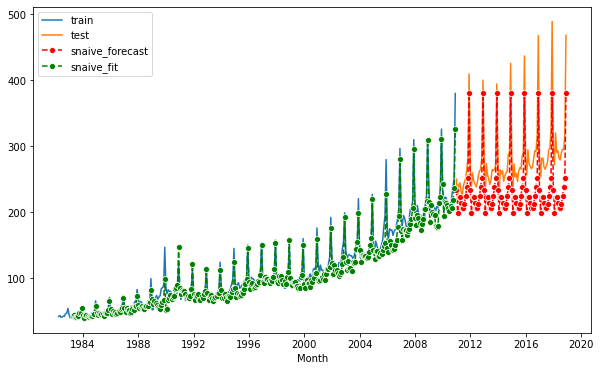

In [73]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(x=train.index, y=train.values, ax=ax, label="train")
sns.lineplot(x=test.index, y=test.values, ax=ax, label="test")
sns.lineplot(x=fc.index, y=fc.values, ax=ax, color='red', marker="o", linestyle='--', label='snaive_forecast')
sns.lineplot(x=snaive_mdl._fit_preds.index, y=snaive_mdl._fit_preds.values, ax=ax, marker="o", linestyle='--', color='green', label="snaive_fit");

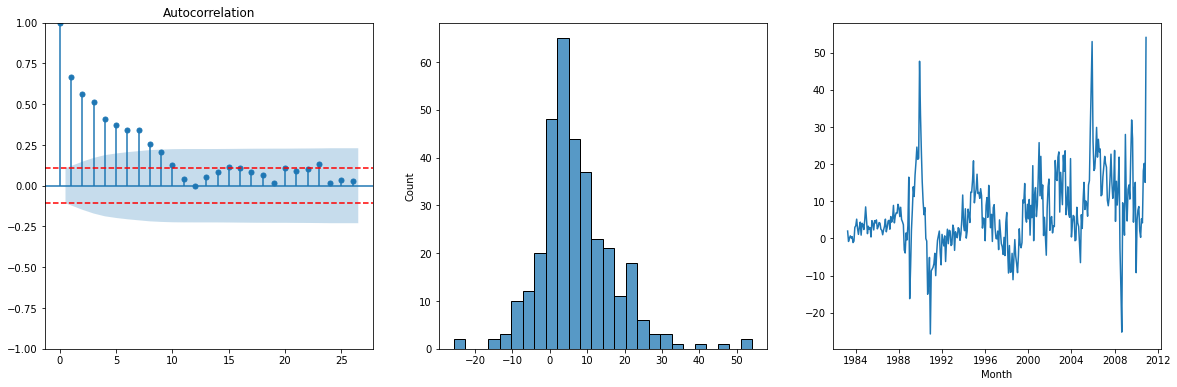

In [74]:
fig, axs = plt.subplots(ncols=3, figsize=(20, 6))
lim = 2/np.sqrt(snaive_mdl._residuals.shape[0])
plot_acf(snaive_mdl._residuals.dropna().values, adjusted=True, ax=axs[0])
axs[0].axhline(y=lim, color='red', linestyle='--')
axs[0].axhline(y=-1*lim, color='red', linestyle='--')

sns.histplot(x=snaive_mdl._residuals.values, ax=axs[1])
sns.lineplot(x=snaive_mdl._residuals.index, y=snaive_mdl._residuals.values, ax=axs[2]);

In [603]:
# fail to reject H_o that residuals are independent and are correlated
acorr_ljungbox(snaive_mdl._residuals.dropna().values)

,lb_stat,lb_pvalue
1,147.134103,7.335263e-34
2,253.152891,1.067943e-55
3,341.518878,1.023367e-73
4,397.686336,8.794247e-85
5,444.000750,9.666909e-94
6,482.484732,4.980229e-101
7,520.880796,2.594417e-108
8,542.070806,6.554852e-112
9,556.182424,5.260330e-114
10,561.333626,3.362919e-114


In [604]:
scaled_error_metrics(snaive_mdl._residuals, ts_data, m=12)

ScaledErrors(MASE=0.9315891233699453, RMSSE=0.9481024364076409)

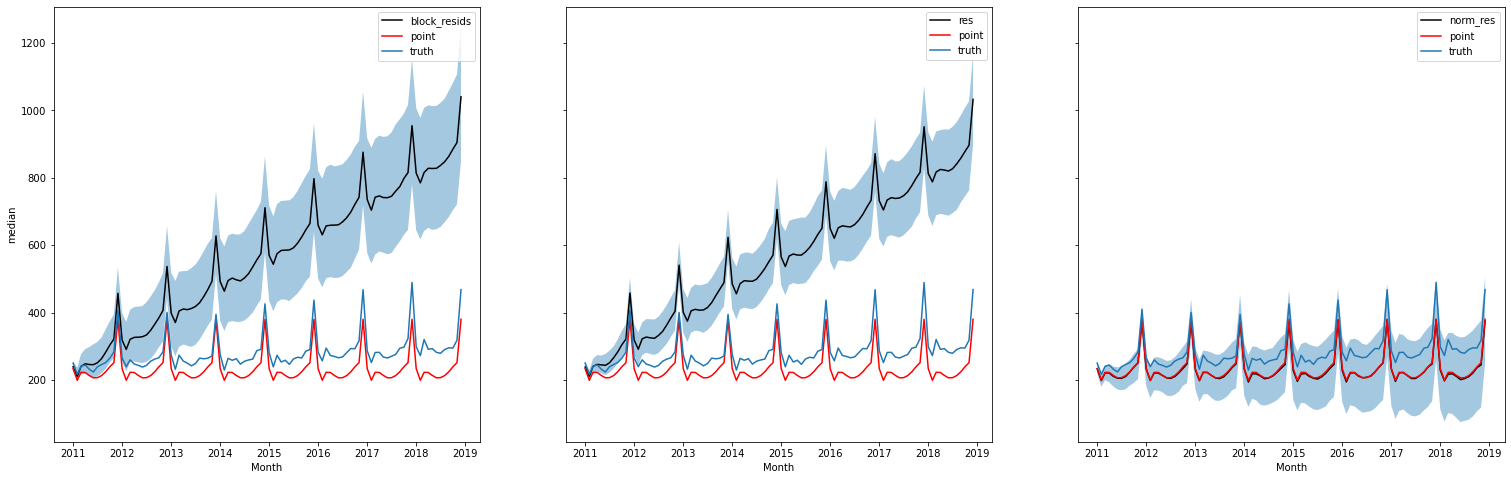

In [140]:
''' block and bootstrap dist forecast seem not to work. I think the first one is because it is not actually doing the decompose approach in chapter 12 and the bootstap because
    the residuals are correlated and far from white noise
'''

ts1 = snaive_mdl.dist_forecast(tsteps=len(test), norm=False)
tsb = snaive_mdl.dist_forecast(tsteps=len(test), norm=False, block_arm=1)
fc1 = snaive_mdl.forecast(tsteps=len(test))
tsn = snaive_mdl.dist_forecast(tsteps=len(test))

fig, axs = plt.subplots(ncols=3, figsize=(26, 8), sharey=True)
tsb.columns = ["10%", "median", "90%"]
ts1.columns = ["10%", "median", "90%"]
tsn.columns = ["10%", "median", "90%"]

sns.lineplot(ax=axs[0], x=tsb.index, y=tsb["median"], color='black', label='block_resids')
sns.lineplot(ax=axs[0], x=fc1.index, y=fc1.values, color='red', label='point')
axs[0].fill_between(tsb.index, tsb["10%"], tsb["90%"], alpha=.4)
sns.lineplot(ax=axs[0], x=test.index, y=test.values, label="truth")

sns.lineplot(x=ts1.index, y=ts1["median"], color='black', label='res', ax=axs[1])
sns.lineplot(ax=axs[1], x=fc1.index, y=fc1.values, color='red', label='point')
axs[1].fill_between(ts1.index, ts1["10%"], ts1["90%"], alpha=.4)
sns.lineplot(ax=axs[1], x=test.index, y=test.values, label="truth")

sns.lineplot(x=tsn.index, y=tsn["median"], color='black', label='norm_res', ax=axs[2])
sns.lineplot(ax=axs[2], x=fc1.index, y=fc1.values, color='red', label='point')
axs[2].fill_between(tsn.index, tsn["10%"], tsn["90%"], alpha=.4)
sns.lineplot(ax=axs[2], x=test.index, y=test.values, label="truth");

In [165]:
# Averge Winkler Score
winkler_score(snaive_mdl._fit_preds, train, .10).mean()

177.86186186186185

In [282]:
stl_decomp = sm.tsa.STL(train, robust=True, seasonal=3).fit()
snaive_stl = SNaiveBenchmark()
drift_stl = DriftBenchmark()

In [286]:
snaive_stl_mdl = snaive_stl.fit(stl_decomp.seasonal, seasonality="Y")
drift_stl_mdl = drift_stl.fit(train - stl_decomp.seasonal)
stl_predict = snaive_stl_mdl._fit_preds + drift_stl_mdl._fit_preds

In [287]:
stl_forecast = snaive_stl_mdl.forecast(test.shape[0]) + drift_stl_mdl.forecast(test.shape[0])

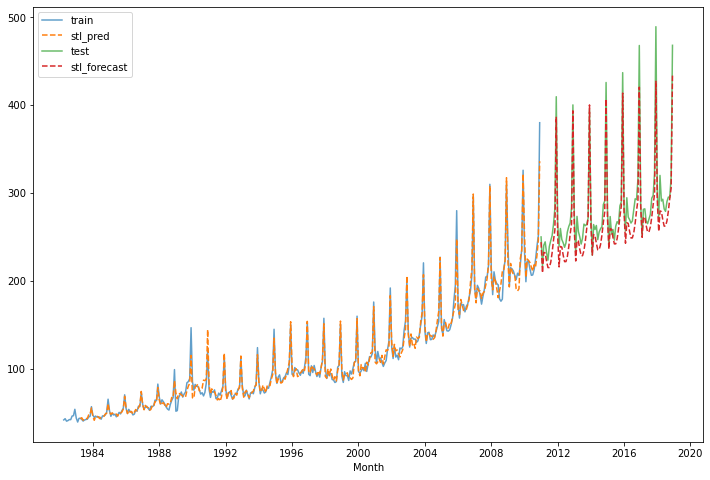

In [296]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.lineplot(x=train.index, y=train.values, label="train", ax=ax, alpha=.7)
sns.lineplot(x=stl_predict.index, y=stl_predict.values, label="stl_pred", ax=ax, linestyle='--')


sns.lineplot(x=test.index, y=test.values, label="test", ax=ax, alpha=.7)
sns.lineplot(x=stl_forecast.index, y=stl_forecast.values, label="stl_forecast", ax=ax, linestyle='--');